# Simple Power Analysis for Password Bypass

---
NOTE: This lab references some training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. 

---

**SUMMARY:** *This tutorial will introduce you to breaking devices by determining when a device is performing certain operations. Our target device will be performing a simple password check, and we will demonstrate how to perform a basic power analysis.*

**LEARNING OUTCOMES:**

* How power can be used to determine timing information.
* Plotting multiple iterations while varying input data to find interesting locations.
* Using difference of waveforms to find interesting locations.


## Setup

First, we will need to do some basic setup for the ChipWhisperer hardware (or software). This exercise works either with real hardware (the ChipWhisperer Nano board) or by simulating the measurements using pre-recorded power traces. Just execute the following cell in order to pull in the needed function definitions, according to your setup:

In [1]:
# Use this script for a simulated version
#%run "traces/password_sim.ipynb" 

# Use this script with the ChipWhisperer Nano board:
%run "traces/password_hw.ipynb"

(ChipWhisperer Other WARNING|File __init__.py:50) Old pip version: 20.3.4, unable to do CW version check


INFO: Found ChipWhisperer😍
Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4775 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4775 bytes


## The Victim Code

The complete victim code can be inspected in the file `passwdcheck.c` or [here in your browser](img/passwdcheck.c.html). Below you can find a screenshot of the main function:

<img src="img/passwdcheck-main.png" alt="Main function of password check code"/>

What it does (after some initializations) is the following:

* Print out a scary message to the user (over the serial interface)
* Wait for the user to send a password
* Compare the sent password with the correct one
* Send an appropriate response to the user

The most interesting part is the for loop between lines 20 and 26. Note that the loop quits once it encounters an incorrect character in the password provided by the user. This is the leakage that we will try to exploit: The number of iterations depends on the number of correct characters from the beginning of the password. This means that there is a *timing side-channel*. Unfortunately, it turns out that this side-channel is difficult to exploit directly: Before sending the reply (line 31), the system waits for several milliseconds. Adding to this the timing noise from the serial communication (on both ends of the interface), the slight variation in execution time cannot be detected reliably by timing the response of the system. 

What we will do instead is using *another side-channel* that will allow us to detect the different execution paths taken by the program. It is based on the fact that the *power consumption* of the processor differs depending on the type of instruction executed. With a bit of luck, looking at captured power traces will do the trick.


## Power Trace Gathering

We have provided a function that simulates sending of passwords to the device and the capturing of power traces. On the real hardware, this comprises the following steps:

* Reset the target
* Read the welcome message (and discard it)
* Send the password guess (with added newline) to the target
* Capture a power trace of 1000 samples
* Read the target's response (and discard it)

Let's test the function with a single letter password:

In [2]:
trace_test = cap_pass_trace("foo\n")

#Basic sanity check
assert(len(trace_test) == 1000)
print("✔️ OK to continue!")

✔️ OK to continue!


Another function can be used to obtain the response of the target system when sending it a password:

In [3]:
resp = pass_response("foo\n")
print (resp)

PASSWORD FAIL



## Exploration

So what can we do with this? While first off - I'm going to cheat, and tell you that we have a preset password that starts with `h`, and it's 5 characters long. But that's the only hint so far - what can you do? While first off, let's try plotting a comparison of `h` to something else.

<IPython.core.display.Javascript object>


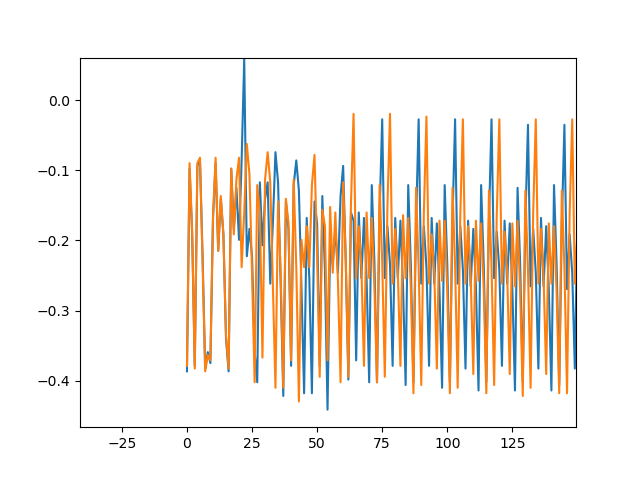

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure()
plt.plot(cap_pass_trace("h\n"))
plt.plot(cap_pass_trace("0\n"))
plt.show()

If you are using the `%matplotlib notebook` magic, you can zoom in at the start. What you want to notice is there is two code paths taken, depending on a correct or incorrect path. Here for example is a correct & incorrect character processed (note that your trace will look different, the examples are taken from another target architecture):
<img src="img/spa_password_h_vs_0_zoomed.png" alt="SPA of Power Analysis" width="450"/>

OK interesting -- what's next? Let's plot every possible password character we could send.

Our password implementation only recognizes characters in the list `abcdefghijklmnopqrstuvwxyz0123456789`, so we're going to limit it to those valid characters for now.

You also may notice the traces are way too long - you might want to make a more narrow plot that only does the first say 100 samples of the power trace.

<div class="alert alert-block alert-warning">
    <p><b>Plotting Note</b>
If using `matplotlib` for plotting, you might need to add a `plt.figure()` at the start to make a new figure. Otherwise you might find your plot ends up in the figure above! If you don't see the plots, sometimes a `plt.show()` is needed at the end.
</div>

<IPython.core.display.Javascript object>


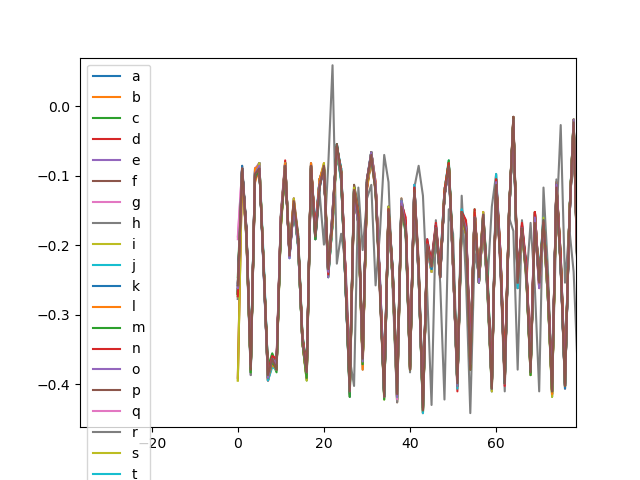

In [6]:
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789'

plt.figure()

# Try out all one-letter passwords and plot the obtained power trace
# FIXME: Your code goes here
for i in alphabet:
    plt.plot(cap_pass_trace(i))

plt.legend(alphabet)

plt.show()

The end result should be if you zoom in, you'll see there is a location where a single "outlier" trace doesn't follow the path of all the other traces. That is great news, since it means we indeed learn something about the system from power analysis.

<img src="img/spa_password_list_char1.png" alt="SPA of Power Analysis against all inputs" width="450"/>

## Automating an Attack against One Character

To start with - we're going to automate an attack against a **single** character of the password. Since we don't know the password (let's assume), we'll use a strategy of comparing all possible inputs together.

An easy way to do this might be to use something that we know can't be part of the valid password. As long as it's processed the same way, this will work just fine. So for now, let's use a password as `0x00` (i.e., a null byte). We can compare the null byte to processing something else:

<IPython.core.display.Javascript object>


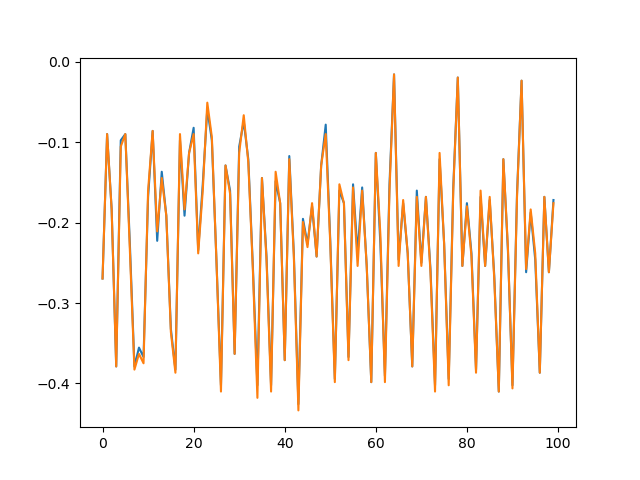

In [7]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
ref_trace = cap_pass_trace("\x00\n")[0:100]
plt.plot(ref_trace)
other_trace = cap_pass_trace("c\n")[0:100]
plt.plot(other_trace)
plt.show()

This will plot a trace with an input of "\x00" - a null password! This is an invalid character, and seems to be processed as any other invalid password (so the two plots actually look quite the same).

Let's make this a little more obvious, and plot the *difference* between a known (wrong) reference and every other capture. You need to write some code that does something like this:

* Capture a reference trace using a null character
* For each valid character, capture a trace and plot the difference between this trace and the reference trace


<IPython.core.display.Javascript object>


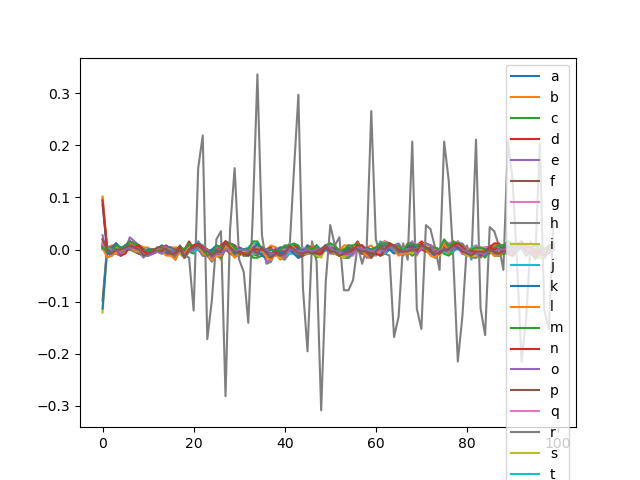

In [10]:
%matplotlib notebook
import matplotlib.pylab as plt

alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789'

plt.figure()

# FIXME: Your code goes here
ref_trace = cap_pass_trace("\x00\n")[0:100]

for i in alphabet:
    plt.plot(cap_pass_trace(i)[0:100] - ref_trace)
    
plt.legend(alphabet)
    
plt.show()    

OK great - hopefully you now see one major "difference". It should look something like this:
    
<img src="img/spa_password_diffexample.png" alt="SPA with Difference" width="450"/>
    

What to do now? Let's make this thing *automatically detect* such a large difference. The idea is to define a *metric* that gives us an estimate on the difference between two traces, i.e. you need to write a function returning a single (integer or floating point) value which reflects this notion. Taking your above loop, modify it to print an indicator of how closely this matches your reference trace. Copy and paste your previous solution and print out the value of our metric for each character:

In [46]:
import numpy as np

# Define metric for the difference between two traces
def trace_diff(trace1, trace2):
    
    # FIXME: Your code goes here
    return sum(abs(cap_pass_trace(trace1)[0:100] - cap_pass_trace(trace2)[0:100]))

# FIXME: Your code goes here
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789'
               
for i in alphabet:
    if(trace_diff("h"+i,"h" + "\x00\n")> 2):
       print(i)
    

0


Now the easy part - modify your above code to automatically print the correct password character. This should be done with a comparison of the computed metric - based on the printed characters, you should see one that is 'higher' than the others. There is basically two solutions to this:

* Compute the metric for all characters and then choose the maximum value
* Set a threshold somewhere reasonable (say I might use `25.0` based on one run) and choose the first character for which the metric exceeds the threshold

While the first solution is more reliable (the threshold may vary with the measurements or later on with the number of guessed characters), the second one is potentially faster, since we can skip parts of the measurements. If you like, you can try both of them and see what works best for you.

## Running a Full Attack

Finally - let's finish this off. Rather than attacking a single character, we need to attack each character in sequence.

If you go back to the plotting of differences, you can try using the correct first character & wrong second character. The basic idea is exactly the same as before, but now we loop through 5 times (assuming that the password has exactly 5 characters), and just build up the password based on brute-forcing each character.

In [49]:
guessed_pw = ""

# FIXME: Your code goes here
# Define metric for the difference between two traces
def trace_diff(trace1, trace2):
    return sum(abs(trace1 - trace2))

# FIXME: Your code goes here
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789'

ref = cap_pass_trace("0x00\n")

for j in range(5):      
    for i in alphabet:
        if(trace_diff(cap_pass_trace(guessed_pw+i),ref) > 20):
            guessed_pw = guessed_pw + i
            print(trace_diff(cap_pass_trace(guessed_pw+i),ref))
            ref  = cap_pass_trace(guessed_pw + "\x00\n")

            print(guessed_pw)
            break
    
print (pass_response(guessed_pw))


49.734375
r
51.01953125
rb
51.6015625
rb4
49.00390625
rb4w
55.69140625
rb4wo
Access granted, Welcome!
https://perso.telecom-paristech.fr/ukuhne/IWCLQFVAWDB2UHBMA3DITK4AOMFEJTMA/


You should get an output that looks like this:

    h
    h4
    h4u
    h4uw
    h4uwe

Only that the real password is not `h4uwe`, but something else. You can test if the final password is correct by asking the device using the function `pass_responce(guessed_pw)`. 

Did you find the correct password? Congrats. Otherwise check the hints at the end of this notebook.

## Breaking a (Really) Secret Password

<div class="alert alert-block alert-warning">
    This only works with the real ChipWhisperer hardware, not using pre-recorded traces. 
</div>

Once your code is working on the example, let's use it on another instance of the same firmware, where the password has been changed (and obfuscated, so you can't see it using a hexdump of the binary...). Execute the cell below in order to flash the firmware to the target system:

In [48]:
fw_path = 'hex/secret-passwdcheck-CWNANO.hex'
programmer = cw.programmers.STM32FProgrammer
cw.program_target(scope, programmer, fw_path)

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 12839 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 12839 bytes


Once this is done, rerun your code and print the system's response.

## Troubleshooting
### Always get 'h'

Some common problems you might run into - first, if you get an output which keeps guessing the first character:

    h
    hh
    hhh
    hhhh
    hhhhh

Check that when you run the `cap_pass_trace` inside the loop (checking the guessed password), are you updating the prefix of the password? For example, the old version of the code (guessing a single character) looked like this:

    trace = cap_pass_trace(c)

But that is always sending our first character only! So we need to send the "known good password so far". In the example code something like this:
   
    trace = cap_pass_trace(guessed_pw + c)

Where `guessed_pw` progressively grows with the known good start of the password.

### Always get 'a'

This looks like it's always matching the first character:

    h
    ha
    haa
    haaa
    haaaa

Check that you update the `ref_trace` - if you re-use the original reference trace, you won't be looking at a reference where the first N characters are good, and the remaining characters are bad. An easy way to do this is again using the `guessed_pw` variable and appending a null + newline:

    trace = cap_pass_trace(guessed_pw + "\x00")

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>